In [1]:
import os

HOME = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Tissue-Detection"
CHECKPOINT_PATH = os.path.join(HOME, "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Tissue-Detection/sam_vit_h_4b8939.pth ; exist: True


In [4]:
import torch

DEVICE = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [5]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [6]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [82]:
import slideio
import numpy as np 
import cv2
import matplotlib.pyplot as plt

1 Image (0, 0, 69720, 55048) 3
(55048, 69720, 3)
(55048, 69720, 3)


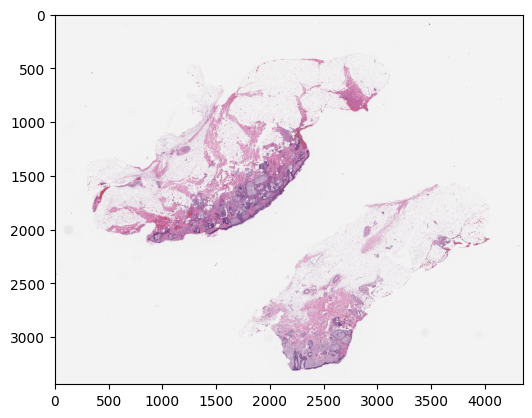

In [85]:
#load the image (this image corresponds to 107 and 167)

impath = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/photoaging/WSI_new/534979_.svs"
slide = slideio.open_slide(impath,'SVS')
num_scenes = slide.num_scenes
scene = slide.get_scene(0)
print(num_scenes, scene.name, scene.rect, scene.num_channels)
full_img = scene.read_block()
print(full_img.shape)

np_im =  np.asarray(full_img) 

print(np_im.shape)

granularity = 16
#dsize is w by h
res = cv2.resize(np_im, dsize=(int(np_im.shape[1]/granularity), int(np_im.shape[0]/granularity)), interpolation=cv2.INTER_CUBIC)


plt.imshow(res)

In [86]:
res.shape

(3440, 4357, 3)

In [10]:
import supervision as sv

# # image_bgr = cv2.imread(IMAGE_PATH)
# image_rgb = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(res)

In [11]:
sam_result[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

In [12]:
sam_result[0]["area"]

2376429

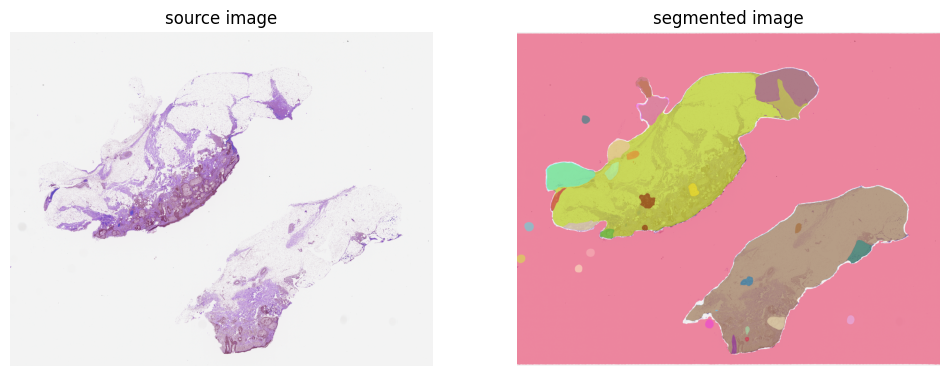

In [13]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=res.copy(), detections=detections)

sv.plot_images_grid(
    images=[res, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [14]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    points_per_batch=64, 
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    min_mask_region_area=1000000,  # Requires open-cv to run post-processing
)


In [36]:
sam_result = mask_generator_2.generate(res)

In [37]:
big_regions = []
for r in sam_result:
    if r["area"] > 1000000: 
        big_regions.append(r)

In [38]:
big_regions

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 1665068,
  'bbox': [1740, 1585, 2283, 1726],
  'predicted_iou': 1.0230765342712402,
  'point_coords': [[2791.203125, 2633.75]],
  'stability_score': 0.9823437929153442,
  'crop_box': [0, 0, 4357, 3440]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 2376459,
  'bbox

In [42]:
big_regions = big_regions[:-1]

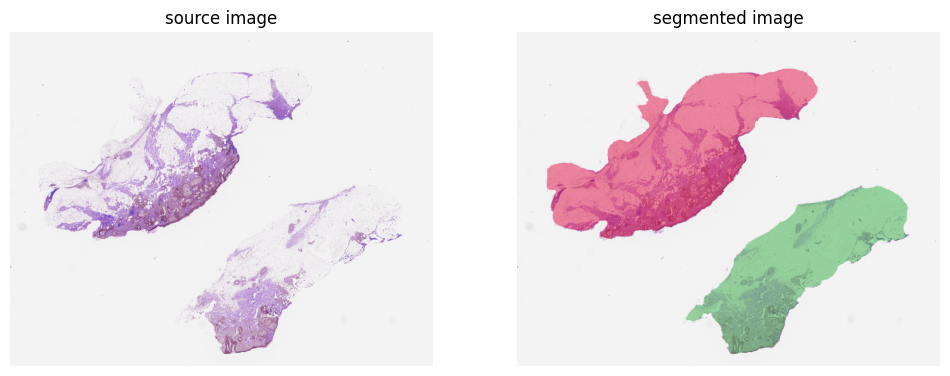

In [43]:
detections = sv.Detections.from_sam(sam_result=big_regions)

annotated_image = mask_annotator.annotate(scene=res.copy(), detections=detections)

sv.plot_images_grid(
    images=[res, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [44]:
# detections

In [49]:
contours = []
for region in big_regions:
    binary_mask = (region["segmentation"] * 255).astype(np.uint8)
    contour, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours.append(contour)

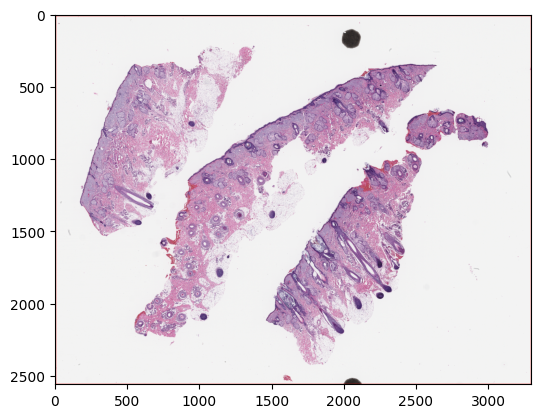

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MPolygon
from matplotlib.collections import PatchCollection

# Assuming 'binary_mask' is your binary mask and 'contours' are the contours found

# Create a figure and a single subplot
fig, ax = plt.subplots(1)

# Display the binary mask
ax.imshow(res)

# For each contour, create a polygon and add it to the plot
for contour in contours:
    # Contour is an array of shape (N, 1, 2). We reshape it to (N, 2)
    reshaped_contour = contour[0].reshape(-1, 2)
    
    # Create a Polygon object
    polygon = MPolygon(reshaped_contour, fill=None, edgecolor='r')
    
    # Add the polygon to the plot
    ax.add_patch(polygon)

plt.show()

In [71]:
from shapely import Polygon

points = contours[0][0]*16
points = np.squeeze(points, axis=1)
# points = points[:, ::-1]

In [77]:
points

array([[59456, 25360],
       [59440, 25376],
       [59360, 25376],
       ...,
       [59568, 25376],
       [59504, 25376],
       [59488, 25360]], dtype=int32)

In [72]:
polygon = Polygon(points)

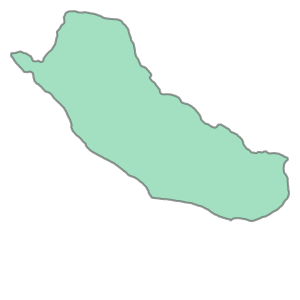

In [73]:
polygon

In [76]:
list(polygon.exterior.coords)

[(59456.0, 25360.0),
 (59440.0, 25376.0),
 (59360.0, 25376.0),
 (59344.0, 25392.0),
 (59264.0, 25392.0),
 (59248.0, 25408.0),
 (59200.0, 25408.0),
 (59184.0, 25424.0),
 (59152.0, 25424.0),
 (59136.0, 25440.0),
 (59104.0, 25440.0),
 (59088.0, 25456.0),
 (59072.0, 25456.0),
 (59056.0, 25472.0),
 (59024.0, 25472.0),
 (59008.0, 25488.0),
 (58976.0, 25488.0),
 (58960.0, 25504.0),
 (58944.0, 25504.0),
 (58928.0, 25520.0),
 (58912.0, 25520.0),
 (58896.0, 25536.0),
 (58864.0, 25536.0),
 (58848.0, 25552.0),
 (58832.0, 25552.0),
 (58816.0, 25568.0),
 (58784.0, 25568.0),
 (58768.0, 25584.0),
 (58720.0, 25584.0),
 (58704.0, 25600.0),
 (58624.0, 25600.0),
 (58608.0, 25616.0),
 (58512.0, 25616.0),
 (58496.0, 25632.0),
 (58416.0, 25632.0),
 (58400.0, 25648.0),
 (58336.0, 25648.0),
 (58320.0, 25664.0),
 (58272.0, 25664.0),
 (58256.0, 25680.0),
 (58208.0, 25680.0),
 (58192.0, 25696.0),
 (58112.0, 25696.0),
 (58096.0, 25712.0),
 (58000.0, 25712.0),
 (57984.0, 25728.0),
 (57904.0, 25728.0),
 (57888.0, 25

## I want to create a general function for this process that returns both of the tissue masks

In [ ]:
import os
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import slideio
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import shapely 

In [284]:
class TissueDetector():
    def __init__(self): #init all the model stuff 
        self.DEVICE = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
        self.CHECKPOINT_PATH = "./sam_vit_h_4b8939.pth"
        self.MODEL_TYPE = "vit_h"
        
        self.sam = sam_model_registry[self.MODEL_TYPE](checkpoint=self.CHECKPOINT_PATH).to(device=self.DEVICE)
        self.mask_generator = SamAutomaticMaskGenerator(
            model=self.sam,
            points_per_side=32,
            points_per_batch=64, 
            pred_iou_thresh=0.86,
            stability_score_thresh=0.92,
            min_mask_region_area=int(1e5), 
        )
        self.reduced_img = None
        self.scale_ratio = None
        self.contours = []
        self.scaled_contours = []
        
    def find_tissue_contours(self, np_im):
        #reset after every call
        self.contours = []
        self.scaled_contours = []
        
        min_dim_size = 1028
        min_dim = min(np_im.shape[1], np_im.shape[0])
        max_dim = max(np_im.shape[1], np_im.shape[0])
        self.scale_ratio = min_dim_size/min_dim
        res = cv2.resize(np_im, dsize=(int(self.scale_ratio*np_im.shape[1]), int(self.scale_ratio*np_im.shape[0])), interpolation=cv2.INTER_CUBIC)
        self.reduced_img = res 
        
        sam_result = self.mask_generator.generate(res)
        
        big_regions = []
        for r in sam_result:
            if r["area"] > 1e5: 
                big_regions.append(r)
        big_regions = big_regions[:-1] #include everything but the big background segmentation
        
        for region in big_regions:
            binary_mask = (region["segmentation"] * 255).astype(np.uint8)
            contour, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            self.contours.append(contour[0]*(int(1/self.scale_ratio)))
            self.scaled_contours.append(contour[0])
                         
    def get_contours(self):
        return self.contours 
    
    def plot_annotations(self):
        # Create a figure and a single subplot
        fig, ax = plt.subplots(1)
        # Display the binary mask
        ax.imshow(self.reduced_img)

        # For each contour, create a polygon and add it to the plot
        for contour in self.scaled_contours:
            # Contour is an array of shape (N, 1, 2). We reshape it to (N, 2)
            reshaped_contour = contour.reshape(-1, 2)
            # Create a Polygon object
            polygon = MPolygon(reshaped_contour, fill=None, edgecolor='r')
            # Add the polygon to the plot
            ax.add_patch(polygon)

        plt.show()
        

In [285]:
td = TissueDetector()

1 Image (0, 0, 69720, 55048) 3
(55048, 69720, 3)
(55048, 69720, 3)


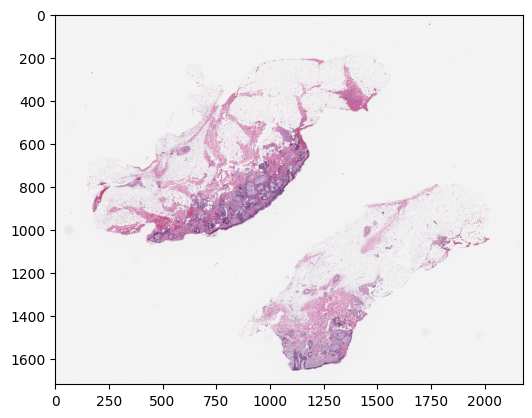

In [149]:
#load the image (this image corresponds to 107 and 167)

impath = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/photoaging/WSI_new/534979_.svs"
slide = slideio.open_slide(impath,'SVS')
num_scenes = slide.num_scenes
scene = slide.get_scene(0)
print(num_scenes, scene.name, scene.rect, scene.num_channels)
full_img = scene.read_block()
print(full_img.shape)

np_im =  np.asarray(full_img) 

print(np_im.shape)

granularity = 32
#dsize is w by h
res = cv2.resize(np_im, dsize=(int(np_im.shape[1]/granularity), int(np_im.shape[0]/granularity)), interpolation=cv2.INTER_CUBIC)


plt.imshow(res)

In [270]:
td.find_tissue_contours(np_im)

In [271]:
contours = td.get_contours()

In [272]:
len(contours)

2

In [273]:
contours[1].shape

(1145, 1, 2)

In [274]:
contours[0]

array([[[56074, 25228]],

       [[56021, 25281]],

       [[55968, 25281]],

       ...,

       [[56286, 25334]],

       [[56233, 25334]],

       [[56127, 25228]]], dtype=int32)

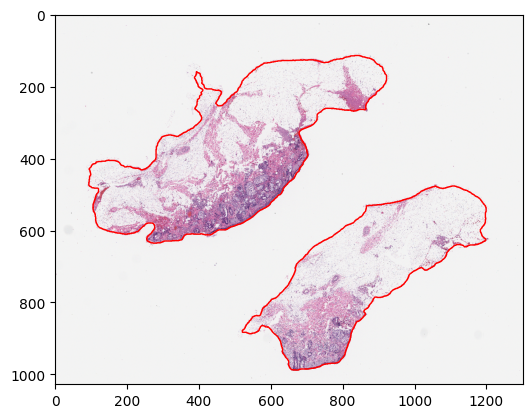

In [275]:
td.plot_annotations()

In [276]:
#load the image (this image corresponds to 107 and 167)

impath = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/photoaging/WSI_new/534956_.svs"
slide = slideio.open_slide(impath,'SVS')
num_scenes = slide.num_scenes
scene = slide.get_scene(0)
print(num_scenes, scene.name, scene.rect, scene.num_channels)
full_img = scene.read_block()
print(full_img.shape)

np_im =  np.asarray(full_img) 

print(np_im.shape)

1 Image (0, 0, 105576, 81898) 3
(81898, 105576, 3)
(81898, 105576, 3)


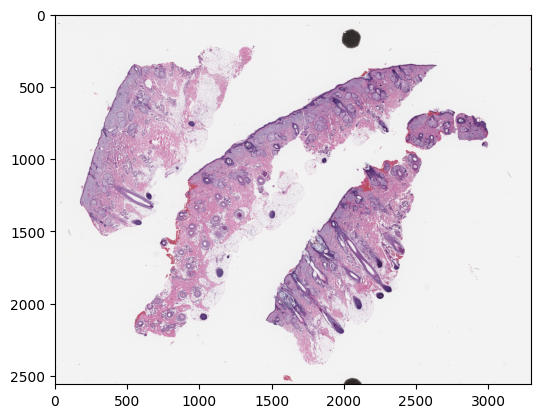

In [277]:

granularity = 32
#dsize is w by h
res = cv2.resize(np_im, dsize=(int(np_im.shape[1]/granularity), int(np_im.shape[0]/granularity)), interpolation=cv2.INTER_CUBIC)


plt.imshow(res)

In [286]:
td.find_tissue_contours(np_im)

In [287]:
contours = td.get_contours()

In [288]:
len(contours)

3

In [289]:
contours[1].shape

(891, 1, 2)

In [290]:
contours[0]

array([[[77894, 30257]],

       [[77815, 30336]],

       [[77420, 30336]],

       ...,

       [[78684, 30336]],

       [[78526, 30336]],

       [[78447, 30257]]], dtype=int32)

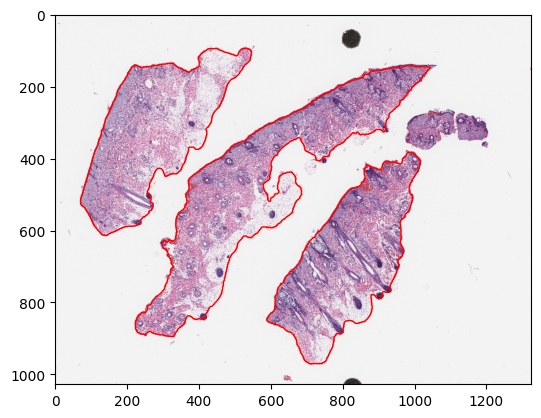

In [291]:
td.plot_annotations()

1 Image (0, 0, 51792, 49581) 3
(49581, 51792, 3)
(49581, 51792, 3)


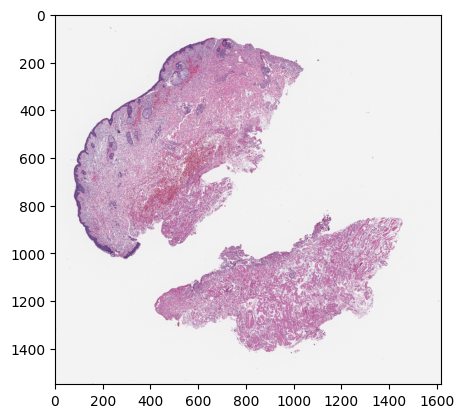

In [292]:
#load the image (this image corresponds to 107 and 167)

impath = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/photoaging/WSI_new/535108_.svs"
slide = slideio.open_slide(impath,'SVS')
num_scenes = slide.num_scenes
scene = slide.get_scene(0)
print(num_scenes, scene.name, scene.rect, scene.num_channels)
full_img = scene.read_block()
print(full_img.shape)

np_im =  np.asarray(full_img) 

print(np_im.shape)


granularity = 32
#dsize is w by h
res = cv2.resize(np_im, dsize=(int(np_im.shape[1]/granularity), int(np_im.shape[0]/granularity)), interpolation=cv2.INTER_CUBIC)


plt.imshow(res)

2


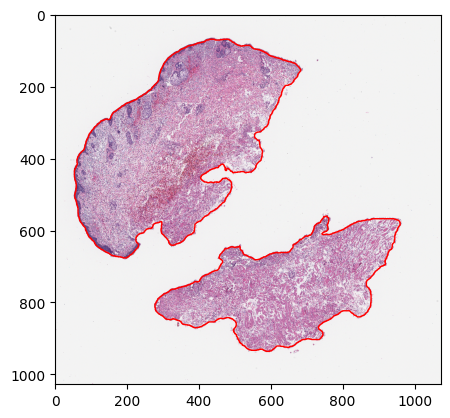

In [293]:
td.find_tissue_contours(np_im)
contours = td.get_contours()
print(len(contours))
td.plot_annotations()